# Compare Drive-to-Transit Access Times in Survey to Skims
Used skims to get access times to transit, but we also have transit boarding TAZs for most transit riders from which we can generate more accurate auto access to transit times. We cannot use these auto skims to transit boarding TAZs to determine travel time and costs of survey respondents for modeling purposes because we need to consider unchosen transit alternatives in modeling the travel behavior of all SDIA travelers (so we have to use skims or some other method to model behavior). We can, however, see how slosely the transit skims replicate survey respondent behavior.

In this notebook, I want to see if skims are representative of survey respondent driving behavior. Because of the way that transit skims are generated, there is no one route connecting one TAZ to another. Instead, transit skims are a collection of averages across different routes for each skim time period (?). This means that we cannot compare the geographic locations of survey respondent transit boarding TAZs and skim transit boarding TAZs given an origin TAZ - we can only compare access times.

In [19]:
# empty - VSCode keeps skipping the first cell in my python notebooks :<

## Set-Up

In [ ]:
import geopandas as gpd
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
geography_file = '../../data/geographies/TAZ15.shp'
processed_survey_data_path = '../../data/processed/data_model_output_full_pii_TAZ.csv'

In [22]:
geographies = gpd.read_file(geography_file).query('~TAZ.isin([3,11])')
survey_data = pd.read_csv(processed_survey_data_path).drop(columns=['Unnamed: 0'])

C:\Users\mwe\AppData\Local\Temp\ipykernel_16712\3616822223.py:2: DtypeWarning: Columns (2,14,15,16,21,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,48,49,55,56,59,60,61,66,71,78,79,81,83,84,87,94,96,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,133,135,139,141,143,151,152,153,156,158,163,168,170,172,178,180,186,195,196,197,200,205,210,215,218,222,238,240,248,274,284,285,286,289,292,293,296,297,298,300,301,320,334,336,338,339,341,353,378,382,390,411,433) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_data = pd.read_csv(processed_survey_data_path).drop(columns=['Unnamed: 0'])


## EDA

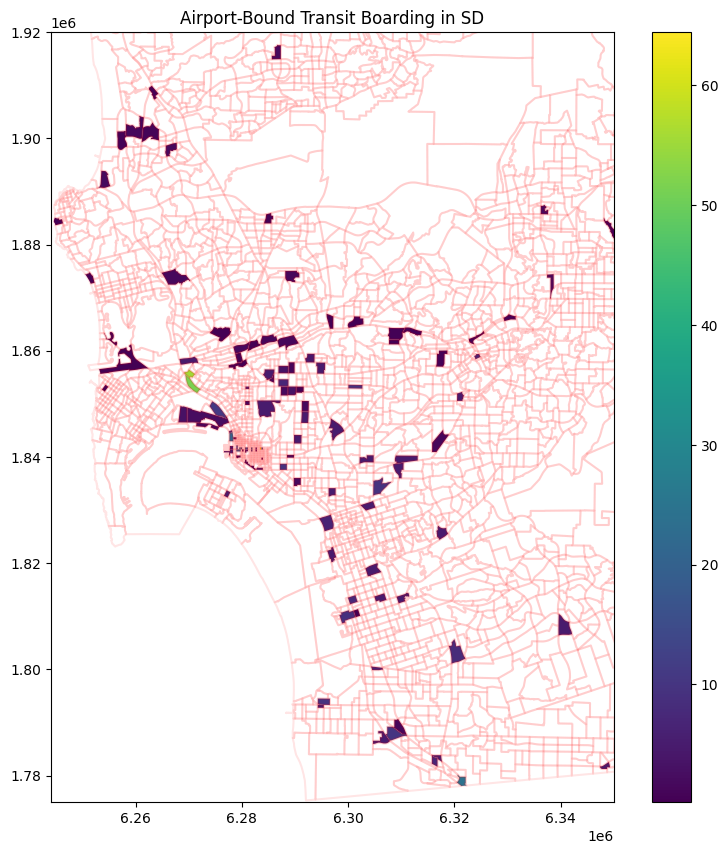

In [23]:
# transit boarding locations by TAZ, focused on central SD
    # as you can see, Old Town TAZs have substantially more (weighted) departed passengers boarding at this location than any other
        # this indicates a pax preference for drop-off/parking at Old Town (likely near Flyer)
    # there are also upticks at San Ysidro and, as shown by the next viz, the 992 route downtown
_, ax = plt.subplots(figsize=(10, 10))
var_prefix = 'transit_boarding'

geographies.boundary.plot(ax = ax, color = 'red', alpha = .1)

(
    gpd.GeoDataFrame(
        geographies.merge(
            survey_data,
            left_on='TAZ',
            right_on=f'{var_prefix}_taz'
        )
        .groupby([f'{var_prefix}_taz','geometry_x'])
        ['weight_departing_only']
        .sum()
        .reset_index()
        .rename(columns={'geometry_x':'geometry'})
    )
    .to_crs(geographies.crs)
    .plot(ax = ax, alpha = 1, column='weight_departing_only', legend=True)
)

# zoom in on central SD
plt.xlim((6.244e6,6.35e6))
plt.ylim((1.775e6,1.92e6))
plt.title('Airport-Bound Transit Boarding in SD')
plt.show()

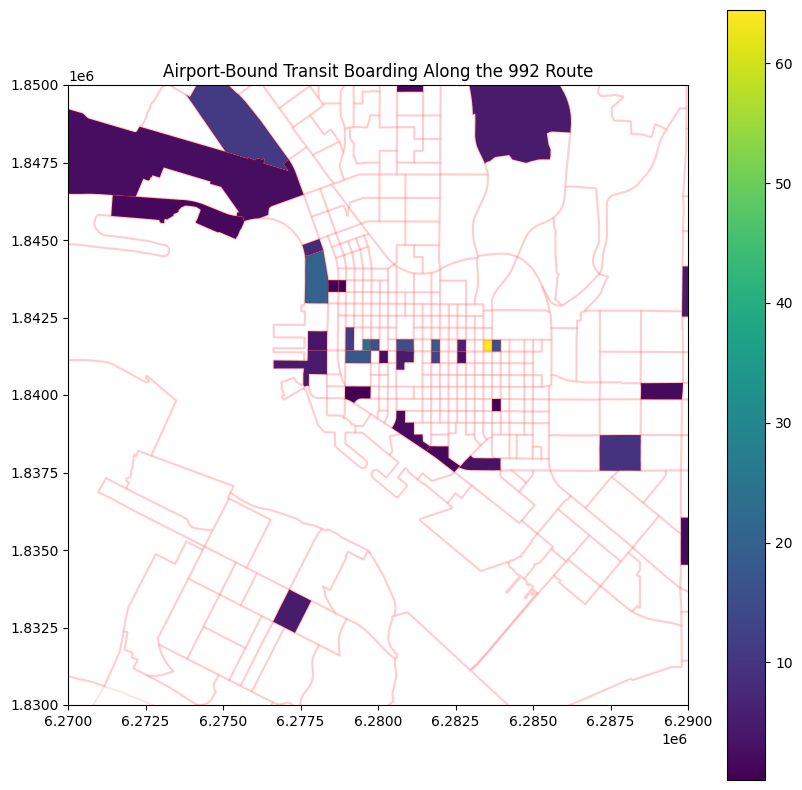

In [24]:
_, ax = plt.subplots(figsize=(10, 10))
var_prefix = 'transit_boarding'

geographies.boundary.plot(ax = ax, color = 'red', alpha = .1)

(
    gpd.GeoDataFrame(
        geographies.merge(
            survey_data,
            left_on='TAZ',
            right_on=f'{var_prefix}_taz'
        )
        .groupby([f'{var_prefix}_taz','geometry_x'])
        ['weight_departing_only']
        .sum()
        .reset_index()
        .rename(columns={'geometry_x':'geometry'})
    )
    .to_crs(geographies.crs)
    .plot(ax = ax, alpha = 1, column='weight_departing_only', legend=True)
)

# zoom in on downtown
plt.xlim((6.27e6,6.29e6))
plt.ylim((1.83e6,1.85e6))
plt.title('Airport-Bound Transit Boarding Along the 992 Route')
plt.show()

## Comparing "Skim PNR ACC Time" to "Auto Skims to Transit Boarding TAZ"

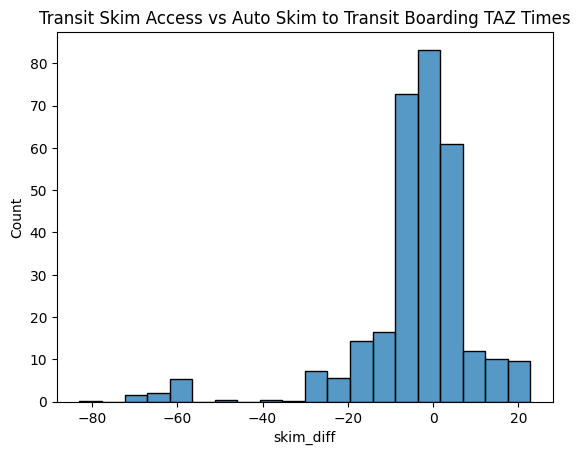

In [39]:
transit_mode_list = ['BUS_992','AIRPORT_FLYER_SHUTTLE','PUBLIC_TRANSPORTATION']
survey_skim_compare = (
    survey_data
        .query(f'main_mode_grouped_label.isin({transit_mode_list})')
        .query(f'access_mode_grouped_label != "WALK"')
        .query('weight_departing_only > 0')
        .copy()
)
survey_skim_compare['skim_diff'] = survey_skim_compare.apply(lambda x: x['transit_acc'] - x['auto_to_transit_time'], axis=1)

sns.histplot(
    data = survey_skim_compare,
    x = 'skim_diff',
    weights = 'weight_departing_only',
    bins = 20,
    )
plt.title('Transit Skim Access vs Auto Skim to Transit Boarding TAZ Times')
plt.show()

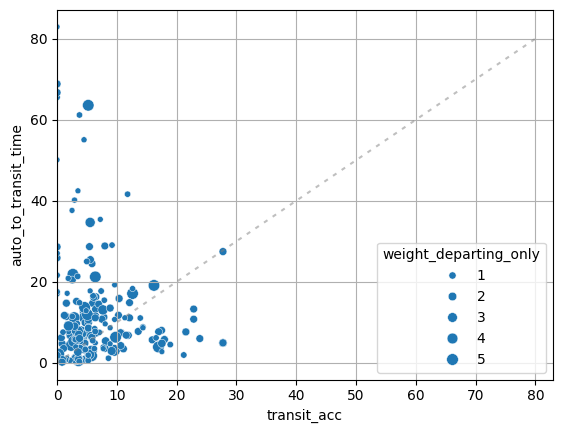

In [49]:
sns.scatterplot(
    data = survey_skim_compare,
    x = 'transit_acc',
    y = 'auto_to_transit_time',
    size = 'weight_departing_only',
    )
plt.plot([0,80],[0,80],alpha=.5,dashes=(2,3),color='gray')

plt.xlim((0,survey_skim_compare['auto_to_transit_time'].max()))
plt.grid()
plt.show()